In [7]:
import csv 
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def txt_c(url, mirror=False):
    data = []
    wav = []
    m = 1

    with open(url, 'r') as file:

        for i in file:
            if not '#' in str(i):
                data.append( [float(x) for x in i.replace('\t', ' ').split(' ')] )
                
    if mirror:
        m = -1
    data, wav = np.array([x[1] * m for x in data]), np.array([x[0] for x in data]) 
    data = (data - data.min()) / (data.max() - data.min())
    return data, wav

In [10]:
water1, water1W = txt_c(r"C:\Users\benja\OneDrive\Skrivebord\DFM data\Gas concentration\water 10000 ppm 5cm^-1.txt", True)
amonia, amoniaW = txt_c(r"C:\Users\benja\OneDrive\Skrivebord\DFM data\Gas concentration\ammonia 10 ppm 5cm^-1.txt", True)
amonia2, amonia2W = txt_c(r"C:\Users\benja\OneDrive\Skrivebord\DFM data\Gas concentration\ammonia high concentration QEPAS measurements.txt", False)

amoniahydroxide, amoniahydroxideW = txt_c(r"C:\Users\benja\OneDrive\Skrivebord\DFM data\Gas concentration\ammonia 10 ppm and water 5000 ppm 5cm^-1.txt", True)

In [26]:
plt.rcParams['figure.figsize'] = (20,10)

In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

import random

In [10]:
class MLP(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()  # IMPORTANT!
        self.input_channels = input_channels
        self.output_channels = output_channels
        
        self.linear1 = nn.Linear(self.input_channels, int(self.input_channels/2))
        self.linear2 = nn.Linear(int(self.input_channels/2), output_channels )
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        #x = F.tanh(x)
        return self.linear2(x)

In [11]:
import copy
import time

def train_loop(lr, model, data_creator, EPOCHS, DEVICE, batch_size):

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    loss_fn = nn.MSELoss()
    
    for epoch in range(EPOCHS):
        model.train()
        correct, total = 0, 0
        
        
       
        data, target = data_creator.mix(batch_size)

        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        output = model(data)


        current_loss = loss_fn(output, target) #loss(output, target)



        current_loss.backward()
        optimizer.step()

        #print('epoch {}, loss function {}'.format(epoch, current_loss.item()))
        
        print( '{}'.format(  (
                        abs(torch.sum(target[:,0] - output[:,0]) ) 
                      + abs(torch.sum(target[:,1] - output[:,1]) ) 
                    ) 
                   / batch_size  )  )

        
    model.eval()
    for i in range(1,10): # sanity check
        data, target = data_creator.mix(1)
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        output = model(data)
        print( '{}'.format(  (
                        abs(torch.sum(target[:,0] - output[:,0]) ) 
                      + abs(torch.sum(target[:,1] - output[:,1]) ) 
                    ) 
                     ) )
        print('targets {} predicted {}'.format(target.tolist(), output.tolist()))
        
        
    
        

In [12]:
class DataCreator():
    def __init__(self, structures, noise=0):
        self.structures = structures
        self.noise = noise
        
    """
    def __call__(self, x):
        
        return mix(batch_size) # Might need to implement __getitem__
    """
    
    def mix(self, batch_size):
        data, label = [], []
        for i in range(batch_size):
            factors = [random.uniform(0, 10) for x in range(len(self.structures))]
            z = sum(factors)

            ratios = [x / z for x in factors] # ratios is both labels and used to create data
            noise = np.random.normal(0,self.noise,len(self.structures[0]))
            
            mix = np.array(  np.sum([s*f 
                                     for s,f in zip(self.structures, ratios)], axis=0)   ) + noise

            data.append( np.array( (mix - mix.min()) / (mix.max() - mix.min()) ) ) 
            label.append( np.array(ratios) ) 
        

        return torch.Tensor(np.array(data)), torch.Tensor(np.array(label))

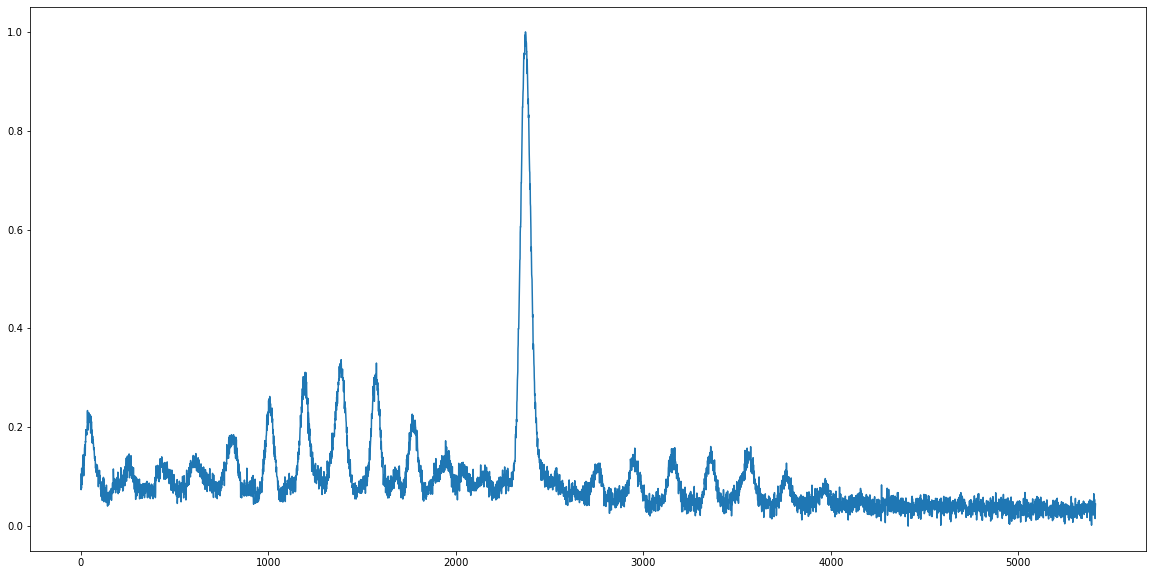

In [43]:
dc = DataCreator([w1, a1], noise = 0.01)

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(torch.cuda.is_available())

True


In [45]:
dc = DataCreator([w1, a1], noise=0.01)
lr = 0.0001
model = MLP(5412, 2).to(device)
epochs = 1

In [46]:
train_loop(lr, model, dc, epochs, device, 1000)

1.0168923139572144
0.8607467412948608
targets [[0.9909312129020691, 0.009068811312317848]] predicted [[0.3696725070476532, 0.24855683743953705]]
0.29076674580574036
targets [[0.6832177042961121, 0.31678229570388794]] predicted [[0.48905062675476074, 0.413381963968277]]
0.2197672724723816
targets [[0.6444103717803955, 0.3555896282196045]] predicted [[0.5475727915763855, 0.4785193204879761]]
0.2130533754825592
targets [[0.47257766127586365, 0.5274223685264587]] predicted [[0.6035830974578857, 0.6094703078269958]]
0.196355938911438
targets [[0.5472567081451416, 0.4527432918548584]] predicted [[0.6106962561607361, 0.5856596827507019]]
0.34609827399253845
targets [[0.49997982382774353, 0.5000201463699341]] predicted [[0.6749083995819092, 0.6711898446083069]]
0.5605977773666382
targets [[0.8401572704315186, 0.15984271466732025]] predicted [[0.4336313307285309, 0.31391453742980957]]
0.17893904447555542
targets [[0.3800562620162964, 0.6199437379837036]] predicted [[0.5245568752288818, 0.585505

In [45]:
from statsmodels.compat import lzip

import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import pandas as pd

# 1. Gauss-Markov Assumptions
The Gauss-Markov assumptions assure that the OLS regression coefficients are the Best Linear Unbiased Estimates or BLUE.

1: Linearity in parameters

2: Random sampling, the observed data represent a random sample from the population

3: No perfect collinearity among covariates

4: Zero conditional mean of error (i.e. E(µ|X) = 0) (also often referred as Exogeneity)

5: Homoskedasticity (constant variance) of the errors

resources: https://towardsdatascience.com/testing-the-assumptions-of-linear-regression-f38857abc08a

# LINE 

While linear regression is a pretty simple task, there are several assumptions for the model that we may want to validate. I follow the regression diagnostic here, trying to justify four principal assumptions, namely LINE in Python:

1: Lineearity

2: Independence (This is probably more serious for time series. I’ll pass it for now)

3: Normality

4: Equal variance (or homoscedasticity)

resources: https://zhiyzuo.github.io/Linear-Regression-Diagnostic-in-Python/
            and https://people.duke.edu/~rnau/testing.htm
            

In [ ]:
# General resources:
# 1: https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/
# plotting resources: https://stackoverflow.com/questions/63895392/seaborn-is-not-plotting-within-defined-subplots
# diagnostics interpretation https://data.library.virginia.edu/diagnostic-plots/
# and https://people.duke.edu/~rnau/regstep.htm


In [ ]:
# For extracting QUEPAS data
# data is an ordered array ['time', 'photoacoustic signal', 'trigger', 'power']
# These can be accesed and isolated by fx for photoacoustic signal data[:,1] or time data[:,0]
import numpy as np
def extract_quepas(path):
    X = []
    with open(path, 'r') as file:
        for i in file:
            if 'nan' in i:
                pass
            else:
                try:
                    data =  [float(x) for x in i.replace('\t', ' ').split(',')] 
                    X.append(data)
                except Exception as e:
                    pass
    return np.array(X)

In [1530]:
# Mixer to test these methods:
def make_signal(signals, cycles):
    X = []
    coef_list = []
    for i in range(cycles):
        factor = random.uniform(0,1)
        coefficients = [factor, 1-factor]
        coef_list.append(coefficients)
        combination = np.array([sig * coef for sig,coef in zip(signals, coefficients)]).sum(axis=0)

        #noise = np.random.normal(size=len(signals[0]), loc = 0, scale = 0.003) # normal distribuation with center = 0.05 and std=0.05
        noise = [random.uniform(0, 0.05) for x in range(len(signals[0]))]
        noise_comb = np.array((combination + noise))
        X.append(noise_comb)
    
    return np.array(X), np.array(coef_list)


In [1531]:
water, waterW = txt_c(r"C:\Users\benja\OneDrive\Skrivebord\DFM data\Gas concentration\water 10000 ppm 5cm^-1.txt", True)
amonia, amoniaW = txt_c(r"C:\Users\benja\OneDrive\Skrivebord\DFM data\Gas concentration\ammonia 10 ppm 5cm^-1.txt", True)

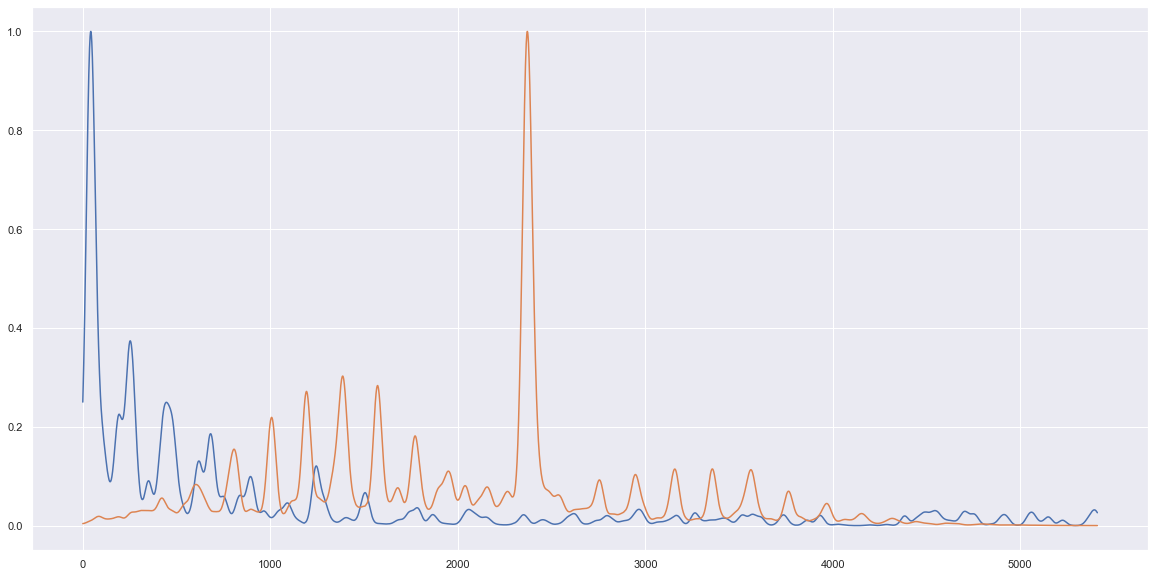

In [1532]:
plt.plot(water)
plt.plot(amonia)

In [1533]:
independents = np.array([water1, amonia])
dependent, coef_list = make_signal(independents,10)

In [1536]:
independents.shape, coef_list.shape
#np.array(coef_list)[0], 
independentsX = np.array([ [(independents[0] * coef_list[i][0]), (independents[1] * coef_list[i][1])] for i in range(len(coef_list))])

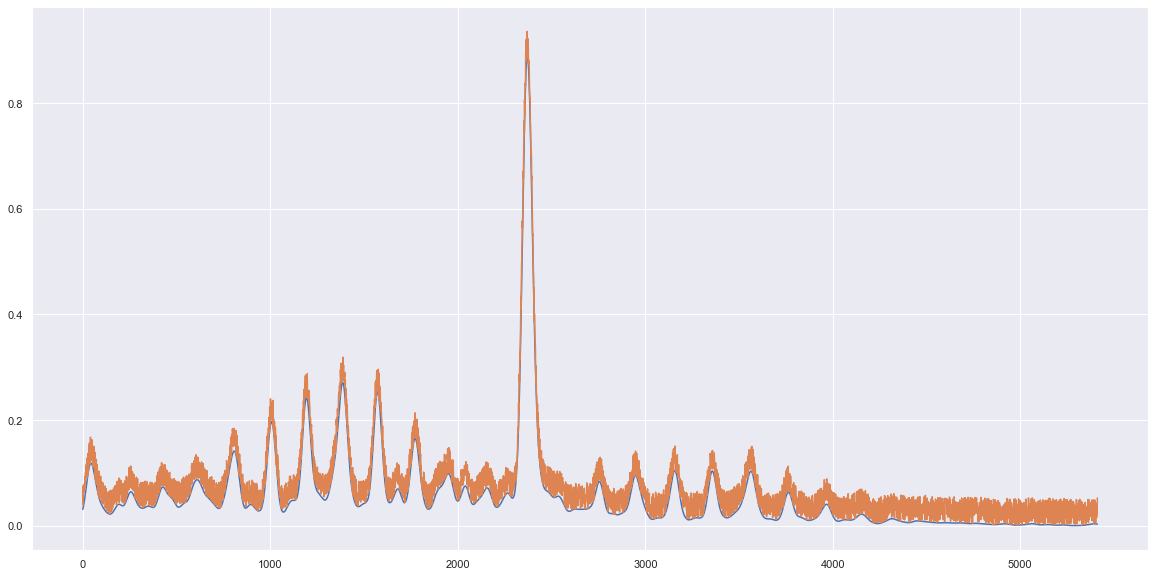

In [1538]:
plt.plot(independentsX[1][0] + independentsX[1][1] )
plt.plot(dependent[1])

In [1551]:
all_dataX = np.column_stack((independentsX, np.expand_dims(dependent, 1)))

#data = pd.DataFrame(all_dataX.T, columns=['water', 'amonia', 'observed'])

#data.head()

all_dataX.shape

(10, 3, 5412)

,water,amonia,observed
0,0.249935,0.003988,0.094267
1,0.263915,0.004042,0.094595
2,0.278654,0.004104,0.120705
3,0.294207,0.004173,0.132187
4,0.310620,0.004251,0.105497


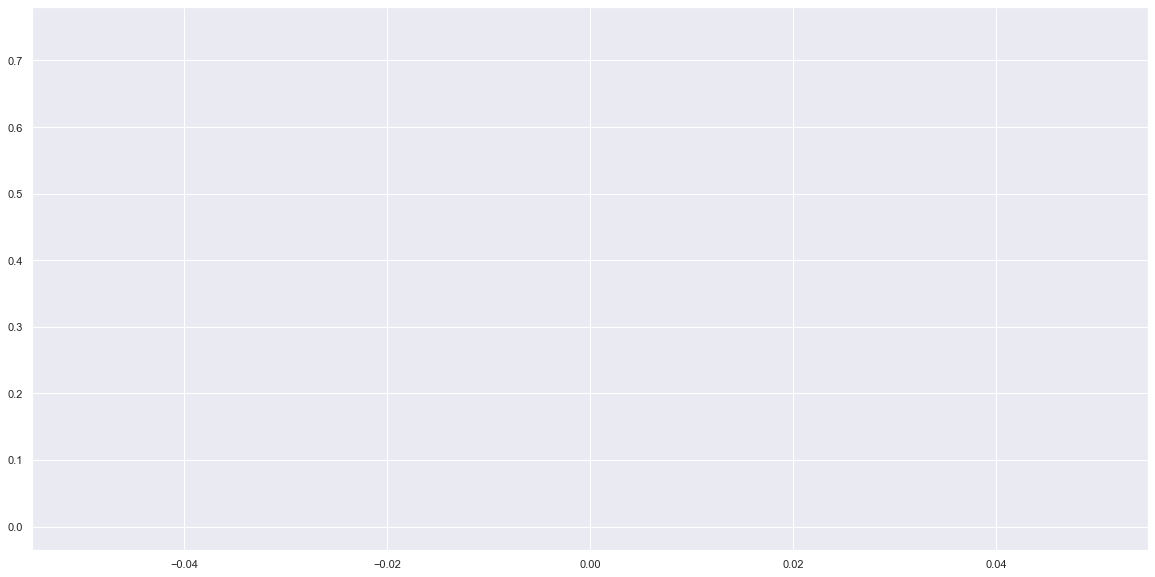

In [1554]:
# Pandas array with constants
independents = np.array([water1, amonia])
dependent, coef_list = make_signal(independents,1)

all_data = np.row_stack((independents, dependent) )

plt.plot(dependent)

data = pd.DataFrame(all_data.T, columns=['water', 'amonia', 'observed'])

#X = sm.add_constant( data[['water', 'amonia']]) 

data.head()

In [1488]:
# understanding formulaes: 
# The variable on the left-hand side of a tilde (~) is called the "dependent variable",
# while the variables on the right-hand side are called the "independent variables" and are joined by plus signs +.
# source: https://www.datacamp.com/tutorial/r-formula-tutorial

est = smf.ols(formula='observed ~ amonia + water',data=data).fit()

print(est.summary())
print('true coefficients {}'.format(coef_list))

                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 8.876e+04
Date:                Thu, 25 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:00:24   Log-Likelihood:                 15227.
No. Observations:                5412   AIC:                        -3.045e+04
Df Residuals:                    5409   BIC:                        -3.043e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0251      0.000    102.538      0.0

In [ ]:
fitted_values = est.fittedvalues.copy().to_numpy() # estimates the estimated model(estimated from coefficients and independent vars)

true_values = data['observed'].values.copy() # Get observation aka dependent variables

residuals = true_val - fitted_values # The difference

#create instance of influence
influence = est.get_influence()

#obtain standardized residuals
std_resids = influence.resid_studentized_internal

#obtain studentized residuals
stud_resids = influence.resid_studentized_external

# Classes for plotting diagnostics

In [1095]:
# base code


import statsmodels
import statsmodels.formula.api as smf
import pandas as pd

import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

# Fitted vs True

[Text(0.5, 1.0, 'Fitted vs True')]

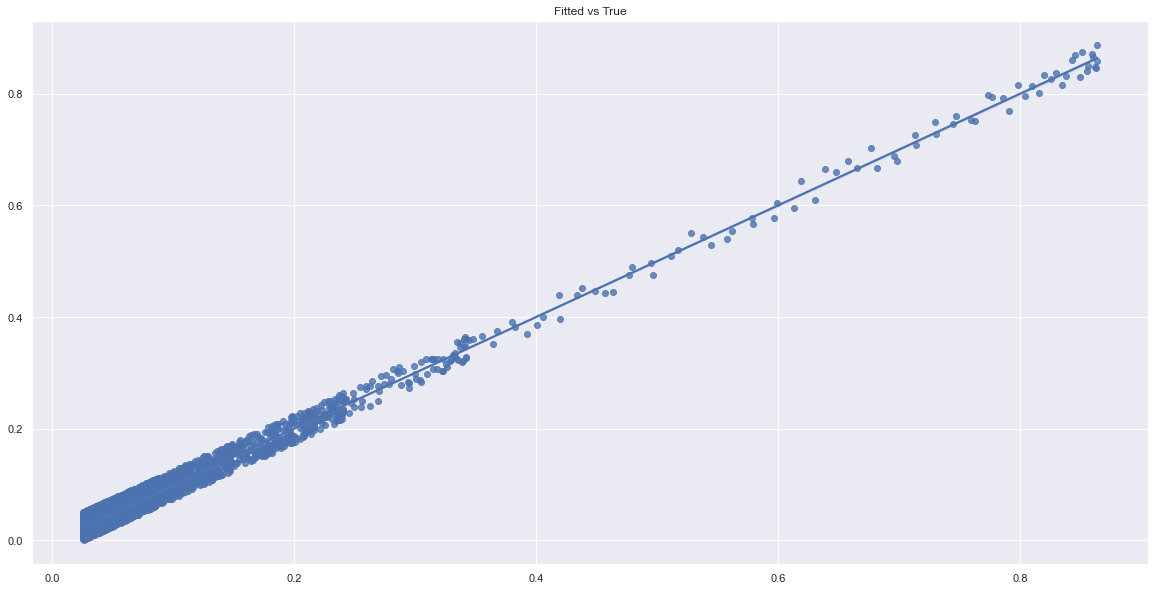

In [1096]:
sns.regplot(x = fitted_values, y = true_values, data = None, scatter = True).set(title='Fitted vs True') 

# Variable relations

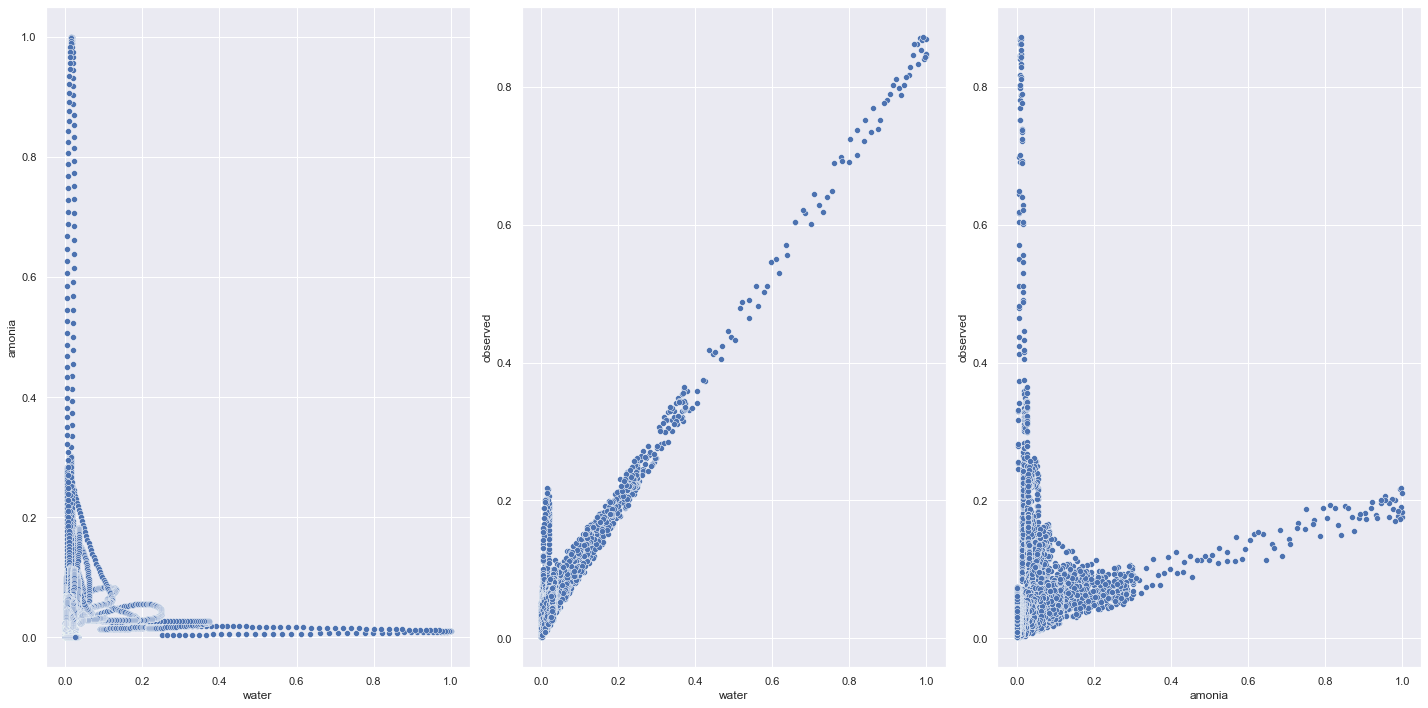

It appears that the relations are linear, with water being the biggest factor


In [1022]:
# select the columns to be plotted
cols = [['water', 'amonia'], ['water', 'observed'], ['amonia', 'observed']]

# create the figure and axes
fig, axes = plt.subplots(1, 3)

for col, ax in zip(cols, axes):
    sns.scatterplot(data=data, x=col[0], y=col[1], ax=ax)

fig.tight_layout()
plt.show()

print('It appears that the relations are linear, with water being the biggest factor')

# Variable distributions
For linear regression, we want to see that the data fits a bell curve, as this indicates normality

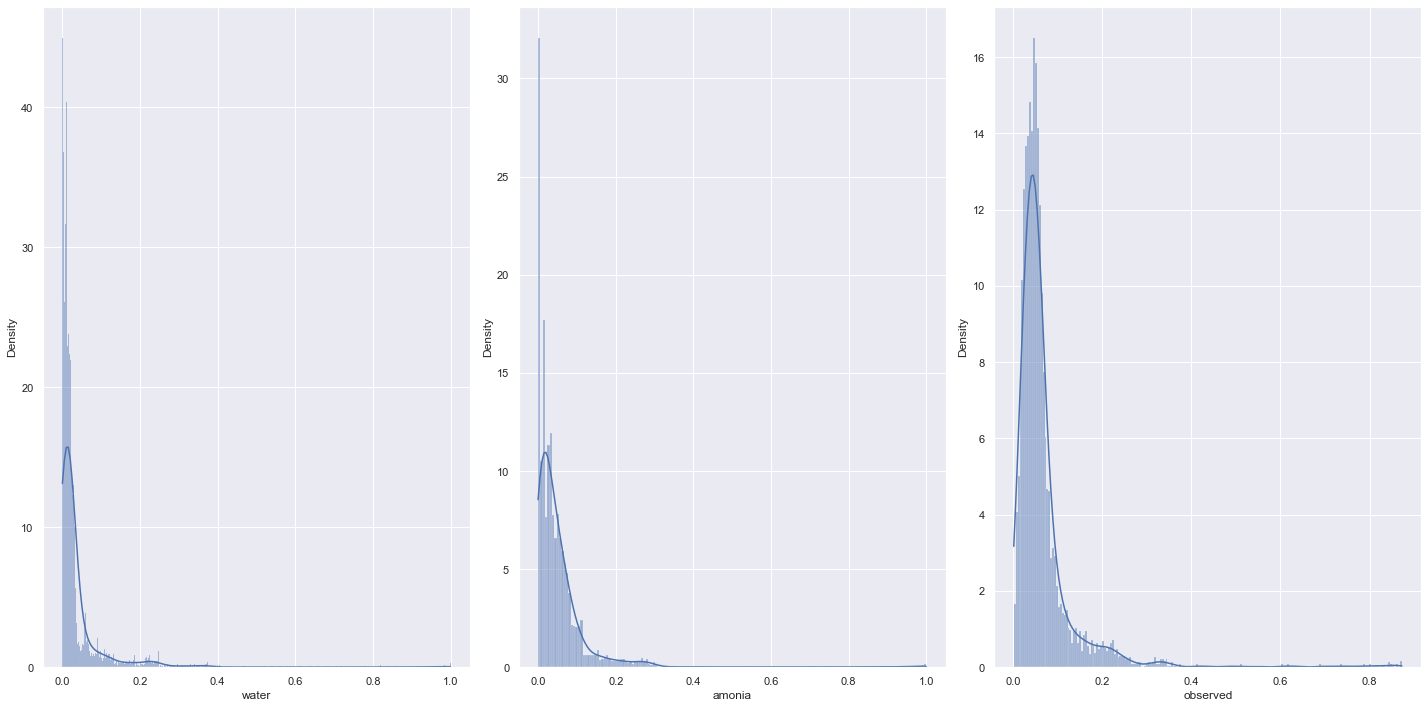

In [1024]:
#sns.displot(data=data, x='observed', kde=True, height=10)

cols = ['water', 'amonia', 'observed']

# create the figure and axes
fig, axes = plt.subplots(1, 3)
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.histplot(data=data[col], kde=True, stat='density', ax=ax)

fig.tight_layout()
plt.show()

In [1033]:
# We could try to transform the data to fit a bell curve(normal dist), this can be done with square, cube or natural log function
# As log is the best(when there are no negative numbers) and out data is part of the set R(positive)
# A log transformation seems to be worth trying ( cant log 0, so i ended up squaring)
data_sqr = np.array([np.square(data['water'].values.copy()), np.square(data['amonia'].values.copy()), np.square(data['observed'].values.copy())])
data_nat_sqr = pd.DataFrame(data_sqr.T, columns=['water', 'amonia', 'observed'])
print(data_nat_sqr.head())

      water    amonia  observed
0  0.062467  0.000016  0.064939
1  0.069651  0.000016  0.060445
2  0.077648  0.000017  0.077822
3  0.086558  0.000017  0.065194
4  0.096485  0.000018  0.079613


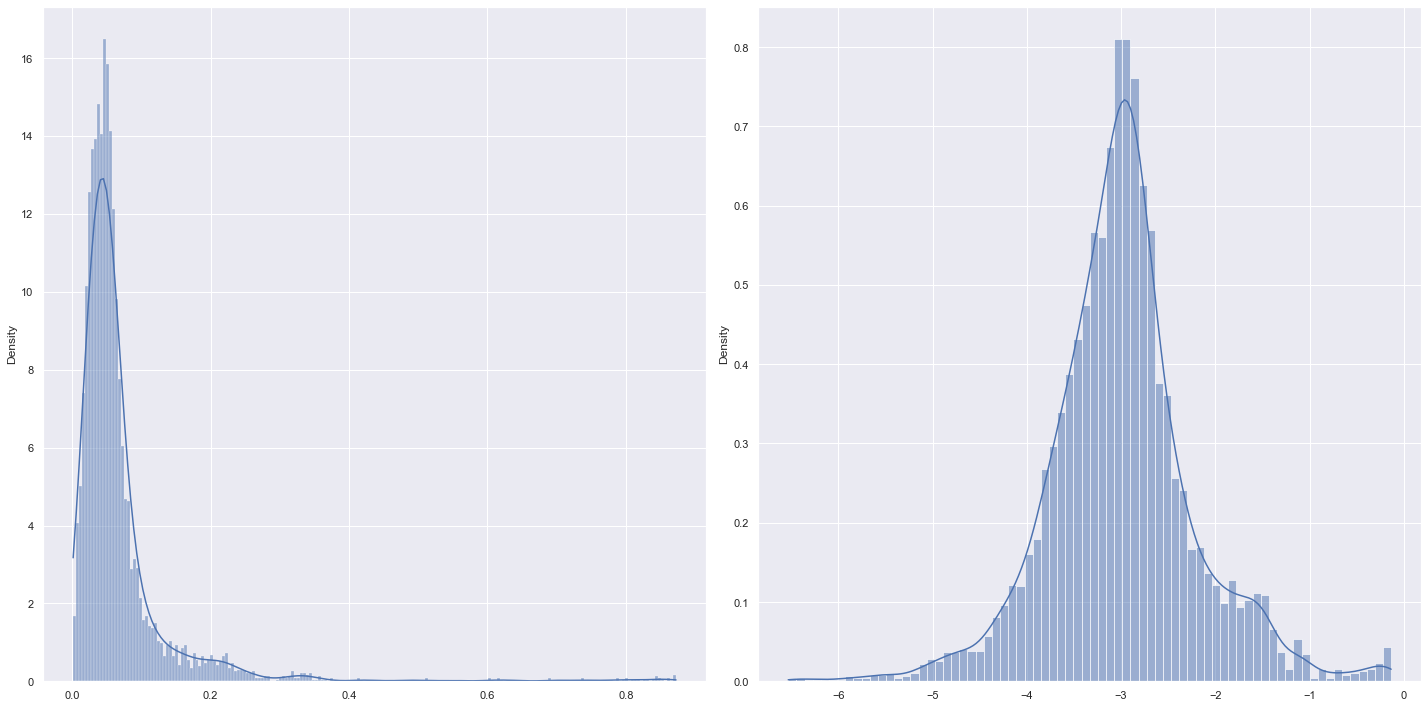

In [1044]:
cols = ['observed']

# create the figure and axes
#fig, axes = plt.subplots(1, 1)
#axes = axes.ravel()  # flattening the array makes indexing easier

fig, axes = plt.subplots(1, 2)
axes = axes.ravel()  # flattening the array makes indexing easier

sns.histplot(data=data['observed'].values.copy(), kde=True, stat='density', ax = axes[0])
sns.histplot(data=np.log(data['observed'].values.copy()), kde=True, stat='density', ax = axes[1])

fig.tight_layout()
plt.show()

In [974]:
cls = Linear_Reg_Diagnostic(est)

# A. Residual vs Fitted values

Graphical tool to identify non-linearity.

In the graph red (roughly) horizontal line is an indicator that the residual has a linear pattern.

if you’re modeling time series data and measurement error changes over time, heteroscedasticity can be present because regression analysis includes measurement error in the error term. For example, if measurement error decreases over time as better methods are introduced, you’d expect the error variance to diminish over time as well.


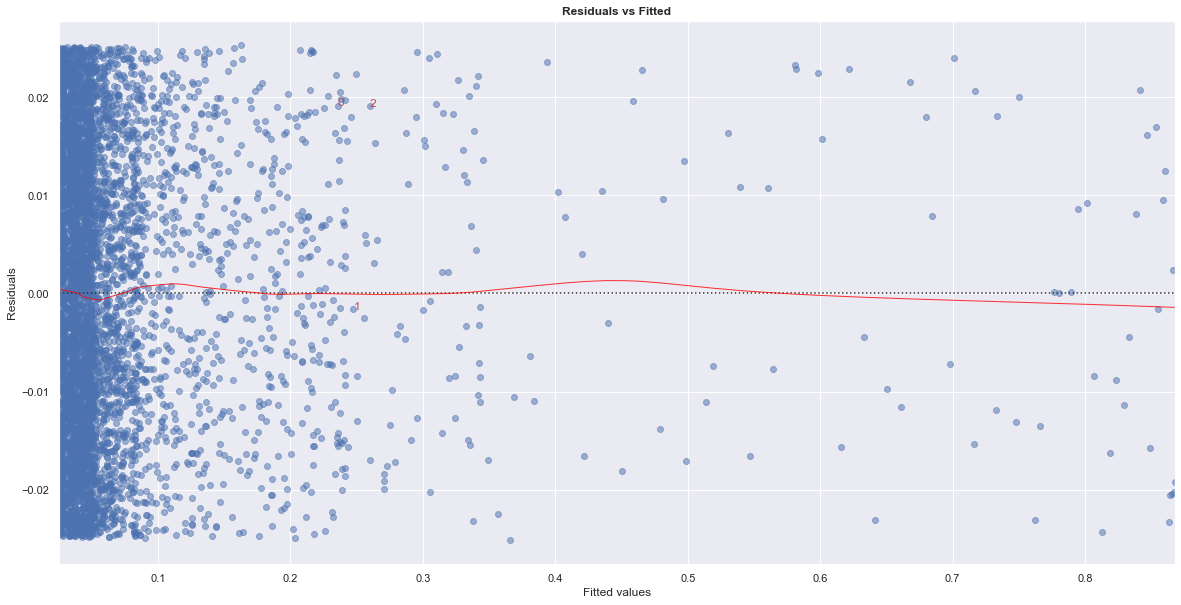

In [975]:
cls.residual_plot();

In [985]:
"""As seen in the residual vs fitted and fitted vs True
the model is very good, but the data is heavily imbalanced to the lower end( it has peaks) 
which is true, so not really a problem.

FOR ANALYSIS VISIT https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/
"""

'As seen in the residual vs fitted and fitted vs True\nthe model is very good, but the data is heavily imbalanced to the lower end( it has peaks) \nwhich is true, so not really a problem.\n\nFOR ANALYSIS VISIT https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/\n'

# B. Standarized Residual vs Theoretical Quantile

This plot is used to visually check if residuals are normally distributed.

Points spread along the diagonal line will suggest so.

# QQ theoretical plot to see if data aligns with normal distribution

Data that aligns closely to the dotted line indicates a normal distribution.
If the points skew drastically from the line, you could consider adjusting your
model by adding or removing other variables in the regression model.


# Intepreting residuals: https://math.illinois.edu/system/files/inline-files/Proj9AY1516-report2.pdf
# And https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html

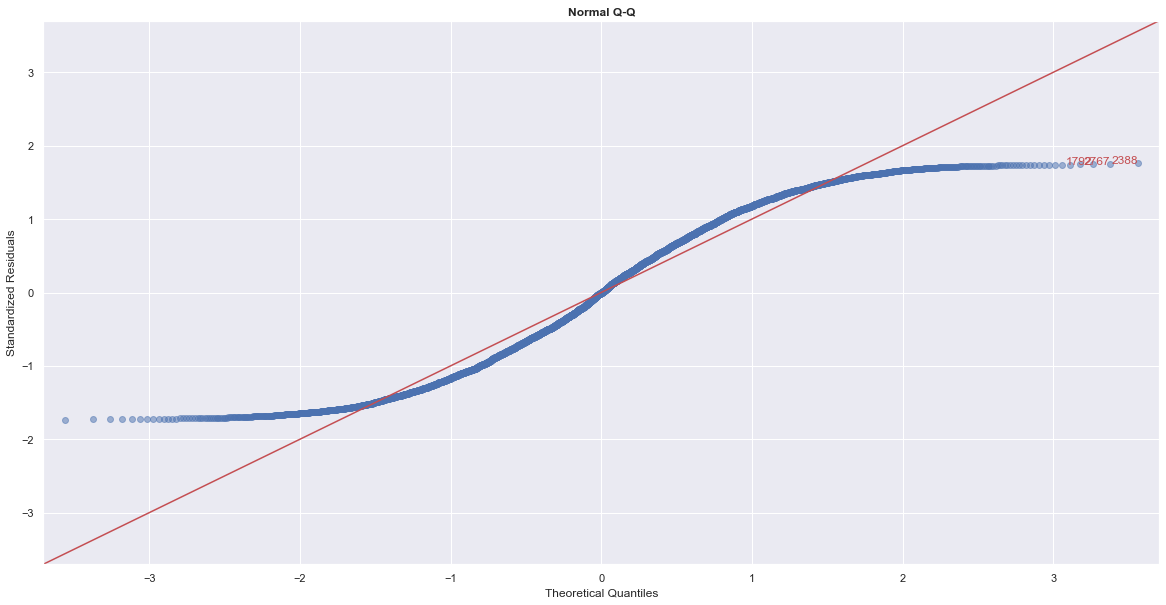

In [976]:
cls.qq_plot();

# Sqrt(Standarized Residual) vs Fitted values / Scale location

It’s also called Spread-Location plot. This plot shows if residuals are spread equally along the ranges of predictors. This is how you can check the assumption of equal variance (homoscedasticity). It’s good if you see a horizontal line with equally (randomly) spread points.

A scale-location plot is a type of plot that displays the fitted values of a regression model along the x-axis 
and the the square root of the standardized residuals along the y-axis


This plot is used to check homoscedasticity of the residuals.

A near horizontal red line in the graph would suggest so.

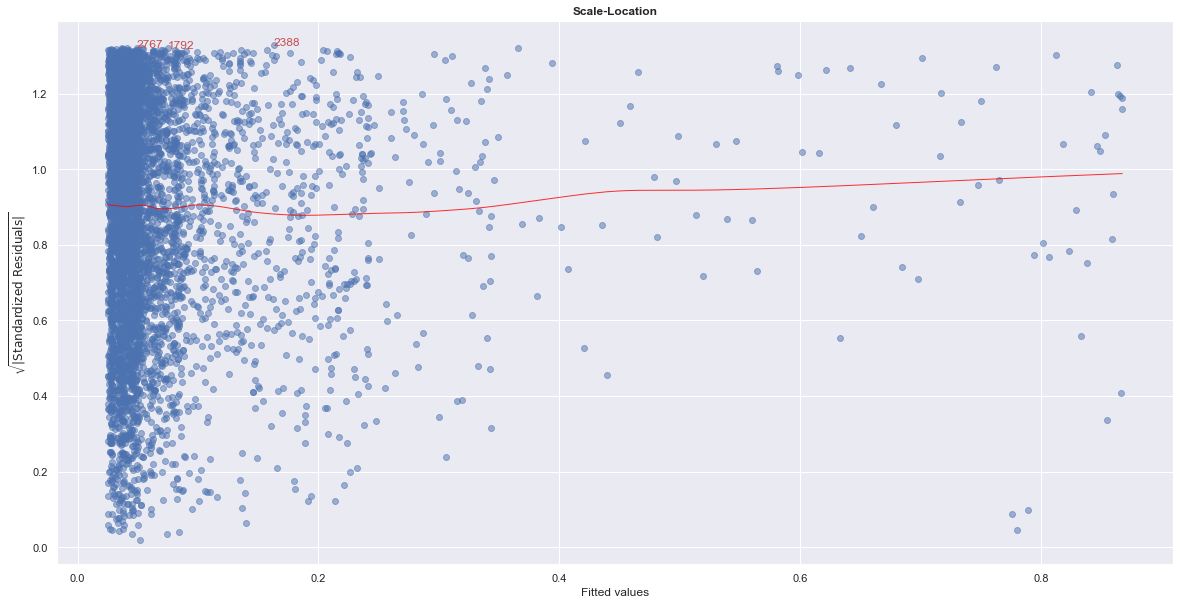

In [978]:
cls.scale_location_plot(); 

# D. Residual vs Leverage / Cooks distance

There are many techniques to remove outliers from a dataset. One method that is often used in regression settings 
is Cook’s Distance. Cook’s Distance is an estimate of the influence of a data point. 
It takes into account both the leverage and residual of each observation. 

Cook’s Distance is a summary of how much a regression model changes when the ith observation is removed

Points falling outside the Cook’s distance curves are considered observation that can sway the fit aka are influential.

Good to have no points outside these curves.

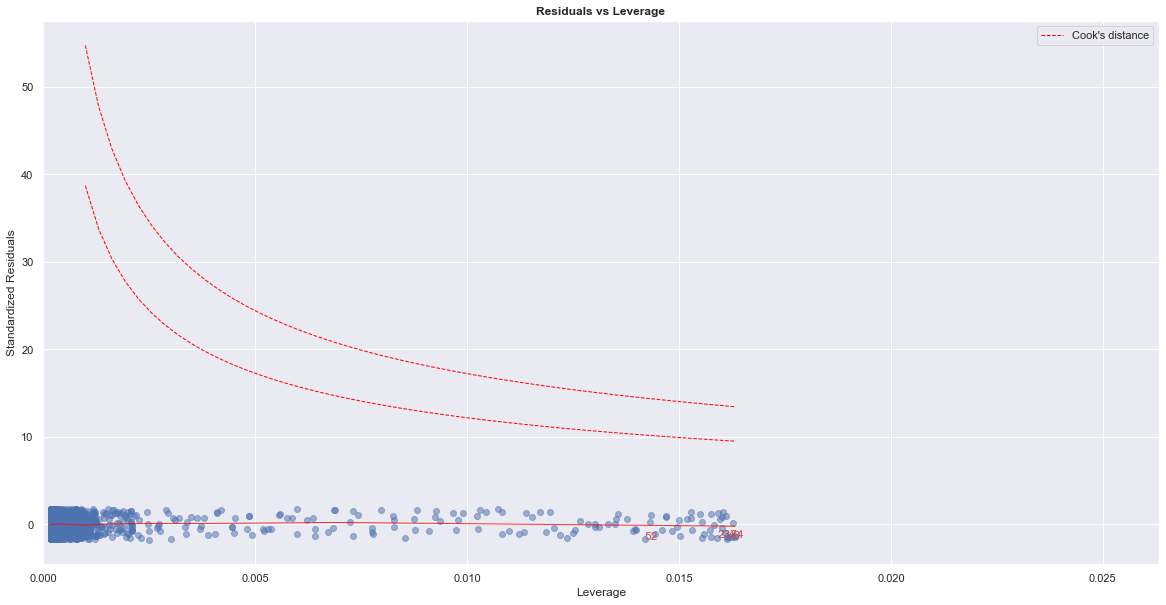

In [988]:
cls.leverage_plot();

Alternatively, all diagnostics can be generated in one go as follows.
Fig and ax can be used to modify axes or plot properties after the fact.

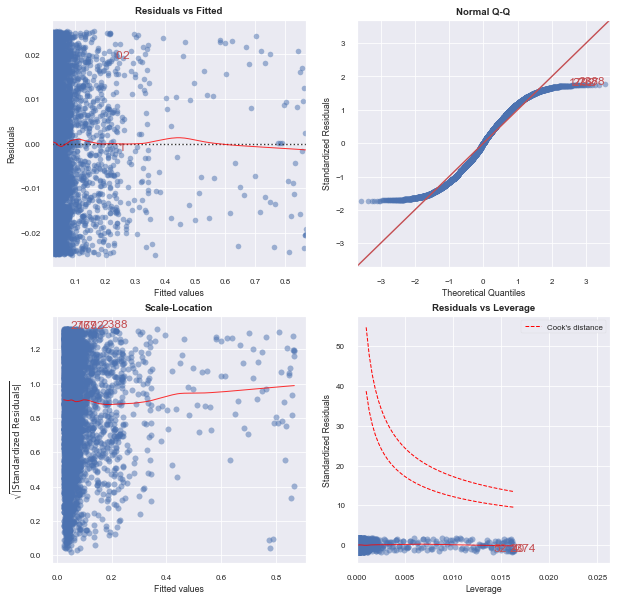

    Features  VIF Factor
2      water        1.01
1     amonia        1.01
0  Intercept        1.53


In [982]:
cls = Linear_Reg_Diagnostic(est)
fig, ax = cls()

# Homoscedacity and breusch pagan and white test
resources: https://www.statology.org/breusch-pagan-test-python/

In regression analysis, heteroscedasticity refers to the unequal scatter of residuals. Specfically, it refers to the case where there is a systematic change in the spread of the residuals over the range of measured values.

Heteroscedasticity is a problem because ordinary least squares (OLS) regression assumes that the residuals come from a population that has homoscedasticity, which means constant variance. When heteroscedasticity is present in a regression analysis, the results of the analysis become hard to trust.

A Breusch-Pagan test uses the following null and alternative hypotheses:

The null hypothesis (H0): Homoscedasticity is present.

The alternative hypothesis: (Ha): Homoscedasticity is not present (i.e. heteroscedasticity exists)
        
        
For any hypothesis test, the decision rule is:

If p-value < level of significance (alpha); then null hypothesis is rejected.
If p-value > level of significance (alpha); then we fail to reject the null hypothesis.
Level of significance (alpha) is chosen by the researcher. How to chose alpha (also known as probability of rejecting the null when it is true/type_I error) is altogether a different issue. It depends on "how sure you want to be before rejecting a null" Most common value of alpha is 0.05

Now, for BP test, the null assumes homoskedasticity. So if p_val < 0.05 (or your chosen alpha value); you reject the null and infer the presence of heteroskedasticity and if p_val > 0.05 (or your chosen alpha value); you fail to reject the null and conclude there may not be heteroskedasticity.

Note: A weakness of the BP test is that it assumes the heteroskedasticity is a linear function of the independent variables. Failing to find evidence of heteroskedasticity with the BP doesn’t rule out a nonlinear relationship between the independent variable(s) and the error variance.

White test provides a flexible functional form that’s useful for identifying nearly any pattern of heteroskedasticity. It allows the independent variable to have a nonlinear and interactive effect on the error variance.

So most commonly used test for homoskedasticity is White test.

In [1067]:

names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']

bp_test = sms.het_breuschpagan(est.resid, est.model.exog)
white_test = sms.het_white(est.resid,  est.model.exog)

bp_test_results = dict(zip(names, bp_test))
white_test_results = dict(zip(names, white_test))

print(bp_test_results)
print(white_test_results)

print('\n Since the p-value is not less than 0.05, we fail to reject the null hypothesis.'
'This means we do not have sufficient evidence to say that heteroscedasticity is present in the regression model.')


{'Lagrange multiplier statistic': 1.3170675197781088, 'p-value': 0.5176097185003851, 'f-value': 0.6583289303198392, 'f p-value': 0.5177572281225831}
{'Lagrange multiplier statistic': 3.668925461266763, 'p-value': 0.597995039371735, 'f-value': 0.7334688195026879, 'f p-value': 0.5982648477087413}

 Since the p-value is not less than 0.05, we fail to reject the null hypothesis.This means we do not have sufficient evidence to say that heteroscedasticity is present in the regression model.


# Testing for linearity 
# with harvey_collier tests (rainbow tests could also be included)

The Harvey-Collier test performs a t-test (with parameter degrees of freedom)
on the recursive residuals. 
If the true relationship is not linear
but convex or concave the mean of the recursive residuals should differ from 0 significantly.



In [1068]:
name = ["t value", "p value"]
hc_test = sms.linear_harvey_collier(est)

dict(zip(name, hc_test))

{'t value': -0.9107632266949952, 'p value': 0.36246073389817235}

# Multicolinearity test
Multicollinearity happens when independent variables in the regression model are highly correlated to each other. It makes it hard to interpret of model and also creates an overfitting problem. It is a common assumption that people test before selecting the variables into the regression model.

In [1072]:
# Corelation matrix between all varibales
data.corr()

,water,amonia,observed
water,1.000000,-0.081534,0.968924
amonia,-0.081534,1.000000,0.105058
observed,0.968924,0.105058,1.000000


The variance inflation factor (VIF), is a measure of multicollinearity.

VIF > 4(or 5) for a variable indicates that it is highly collinear with the other input variables.

The second method to check multi-collinearity is to use the Variance Inflation Factor(VIF) for each independent variable. It is a measure of multicollinearity in the set of multiple regression variables. The higher the value of VIF the higher correlation between this variable and the rest.

In [1074]:
cls.vif_table()

    Features  VIF Factor
2      water        1.01
1     amonia        1.01
0  Intercept        1.53


# Test of violation of independence
re potentially very serious in time series regression models: serial correlation in the errors (i.e., correlation between consecutive errors or errors separated by some other number of periods) means that there is room for improvement in the model, and extreme serial correlation is often a symptom of a badly mis-specified model. Serial correlation (also known as autocorrelation”) is sometimes a byproduct of a violation of the linearity assumption, as in the case of a simple (i.e., straight) trend line fitted to data which are growing exponentially over time. 

Independence can also be violated in non-time-series models if errors tend to always have the same sign under particular conditions, i.e., if the model systematically underpredicts or overpredicts what will happen when the independent variables have a particular configuration. 



In [1]:
import os

os.getcwd()

'C:\\Users\\benja\\Documents\\jupyter notebooks'